In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from collections import defaultdict

from scipy.linalg import svd
import seaborn as sns

from causal_optoconnectics.graphics import regplot, scatterplot, probplot
from causal_optoconnectics.core import Connectivity
from causal_optoconnectics.tools import (
    compute_trials_multi,
    compute_trials,
    decompress_events,
    error,
    error_norm,
    min_error,
    conditional_probability,
    process,
    process_metadata
)
from utils import savefig
%matplotlib inline

# Process results

In [3]:
rparams = {
    'x1': 11,
    'x2': 13,
    'y1': 12,
    'y2': 14,
    'z1': 9,
    'z2': 11,
}

In [4]:
# data_path = pathlib.Path('../scripts/full-confounding-3-neurons/sweep_1')
data_path = pathlib.Path('/home/users/bjornmik/datasets/full-confounding-3-neurons/sweep_1/')

In [5]:
paths = list(data_path.glob('*.npz'))
data_df = pd.DataFrame({'path': paths})

In [6]:
data_df

,path
0,/home/users/bjornmik/datasets/full-confounding...
1,/home/users/bjornmik/datasets/full-confounding...
2,/home/users/bjornmik/datasets/full-confounding...
3,/home/users/bjornmik/datasets/full-confounding...
4,/home/users/bjornmik/datasets/full-confounding...
5,/home/users/bjornmik/datasets/full-confounding...
6,/home/users/bjornmik/datasets/full-confounding...
7,/home/users/bjornmik/datasets/full-confounding...


In [18]:
pbar = tqdm(total=len(data_df))
values = pd.DataFrame()
for i, row in data_df.iterrows():
    data = np.load(row.path, allow_pickle=True)
    X = data['data']
    W_0 = data['W_0']
    W = data['W']
    params = data['params'][()]
    params['weight'] = W_0[1,2]
    params.update(rparams)
    data_df.loc[i, params.keys()] = params.values()
    n_neurons = params['n_neurons']
    stim_index = len(W_0)
    trials = compute_trials_multi(X, len(W_0), stim_index)
    
    results_meta = pd.DataFrame(process_metadata(range(len(W_0)), range(len(W_0)), W=W, stim_index=stim_index))
    sample = pd.DataFrame([process(
        source=source, target=target, W=W, stim_index=stim_index, trials=trials, params=params, rectify=False) 
           for source, target in results_meta.pair.values])
    
    data_df.loc[i, 'beta_ols_AC'] = sample.query('source==0 and target==2').beta_ols.values
    data_df.loc[i, 'beta_iv_AC'] = sample.query('source==0 and target==2').beta_iv.values
    data_df.loc[i, 'beta_brew_AC'] = sample.query('source==0 and target==2').beta_brew.values
    
    data_df.loc[i, 'beta_ols_BC'] = sample.query('source==1 and target==2').beta_ols.values
    data_df.loc[i, 'beta_iv_BC'] = sample.query('source==1 and target==2').beta_iv.values
    data_df.loc[i, 'beta_brew_BC'] = sample.query('source==1 and target==2').beta_brew.values
    
    data_df.loc[i, 'beta_ols_did_AC'] = sample.query('source==0 and target==2').beta_ols_did.values
    data_df.loc[i, 'beta_iv_did_AC'] = sample.query('source==0 and target==2').beta_iv_did.values
    data_df.loc[i, 'beta_brew_did_AC'] = sample.query('source==0 and target==2').beta_brew_did.values
    
    data_df.loc[i, 'beta_ols_did_BC'] = sample.query('source==1 and target==2').beta_ols_did.values
    data_df.loc[i, 'beta_iv_did_BC'] = sample.query('source==1 and target==2').beta_iv_did.values
    data_df.loc[i, 'beta_brew_did_BC'] = sample.query('source==1 and target==2').beta_brew_did.values
    pbar.update(1)
pbar.close()
data_df = data_df.sort_values('weight')

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
data_df.to_csv(data_path / 'summary.csv')

In [20]:
from causal_optoconnectics.buzsaki import transfer_probability

In [21]:
def convert_index_to_times(X, params):
    times = np.arange(params['n_time_step']) * params['dt']
    spikes = np.empty((sum([len(x) for x in X]),2))
    prev_t, prev_len = 0, 0
    for x in X:
        s = x.copy().astype(float)
        s[:,1] = times[x[:,1]]
        s[:,1] = s[:,1] + prev_t
        spikes[prev_len:len(s)+prev_len, :] = s
        prev_t = s[-1,1] + 100
        prev_len += len(s)
    return spikes

In [22]:
trans_prob_params = {
    'y_mu': 1.5e-3,
    'y_sigma': 1e-3,
    'bin_size': 1e-3,
    'limit': 2e-2,
    'hollow_fraction': .6,
    'width': 60
}

pbar = tqdm(total=len(data_df))
values = pd.DataFrame()
for i, row in data_df.sort_values('weight').iterrows():
    data = np.load(row.path, allow_pickle=True)
    X = data['data']
    params = data['params'][()]
    spikes = convert_index_to_times(X, params)

    A_spikes = spikes[spikes[:,0]==0, 1]
    B_spikes = spikes[spikes[:,0]==1, 1]
    C_spikes = spikes[spikes[:,0]==2, 1]
    
    tr_AC = transfer_probability(A_spikes, C_spikes, **trans_prob_params)[0]
    tr_BC = transfer_probability(B_spikes, C_spikes, **trans_prob_params)[0]

    data_df.loc[i, 'tr_AC'] = tr_AC
    data_df.loc[i, 'tr_BC'] = tr_BC
    pbar.update(1)
pbar.close()

  0%|          | 0/8 [00:00<?, ?it/s]

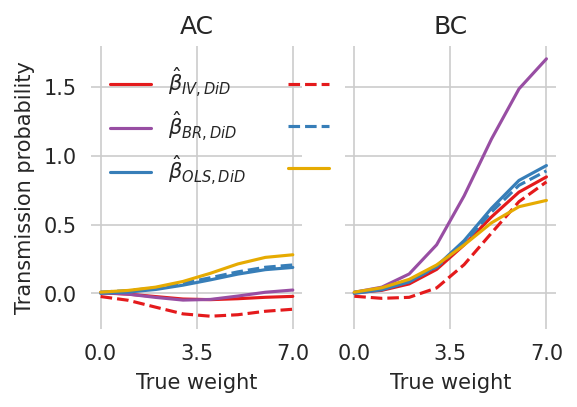

In [51]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, dpi=150, figsize=(4,2.5))
axba, axbb = axs.flatten()

axba.plot(data_df.weight.values, data_df.beta_iv_did_AC.values, color='#e41a1c', label=r'$\hat{\beta}_{IV,DiD}$')
axbb.plot(data_df.weight.values, data_df.beta_iv_did_BC.values, color='#e41a1c')

axba.plot(data_df.weight.values, data_df.beta_brew_did_AC.values, color='#984ea3', label=r'$\hat{\beta}_{BR,DiD}$')
axbb.plot(data_df.weight.values, data_df.beta_brew_did_BC.values, color='#984ea3')

axba.plot(data_df.weight.values, data_df.beta_ols_did_AC.values, color='#377eb8', label=r'$\hat{\beta}_{OLS,DiD}$')
axbb.plot(data_df.weight.values, data_df.beta_ols_did_BC.values, color='#377eb8')

axba.plot(data_df.weight.values, data_df.beta_iv_AC.values, color='#e41a1c', label=r'$\hat{\beta}_{IV}$', ls='--')
axbb.plot(data_df.weight.values, data_df.beta_iv_BC.values, color='#e41a1c', ls='--')

axba.plot(data_df.weight.values, data_df.beta_ols_AC.values, color='#377eb8', label=r'$\hat{\beta}_{OLS}$', ls='--')
axbb.plot(data_df.weight.values, data_df.beta_ols_BC.values, color='#377eb8', ls='--')

axba.plot(data_df.weight.values, data_df.tr_AC.values, color='#e6ab02', label=r'$\hat{\beta}_{CCH}$')
axbb.plot(data_df.weight.values, data_df.tr_BC.values, color='#e6ab02')

# axba.axhline(0, color='k', lw=1, ls='-', alpha=0.2, zorder=0)
# axbb.axhline(0, color='k', lw=1, ls='-', alpha=0.2, zorder=0)

axba.set_ylabel('Transmission probability')
axba.set_xlabel('True weight')
axbb.set_xlabel('True weight')
axba.set_title('AC')
axbb.set_title('BC')
sns.despine(left=True, bottom=True)
axba.set_xticks([0,3.5,7])
# axbb.set_yticks([0,round(max(results['cond_AC']),1)])
# axbb.set_ylim([-.15,round(max(results['cond_AC']))])

axba.legend(frameon=False, loc='upper left', ncol=2)
# axbb.legend(frameon=False, loc='upper left')
savefig('sweep_0_three_neurons')

In [39]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [40]:
class Connectivity:
    def __init__(self, pre, post, params):
        x1, x2, y1, y2, z1, z2 = map(
            params.get, ['x1', 'x2', 'y1', 'y2', 'z1', 'z2'])
        self.n_trials, n_bins = pre.shape
        assert n_bins % 2 == 0
        n_response_y = y2-y1
        n_response_x = x2-x1

        self.x = pre[:, x1:x2].sum(1).astype(bool)
        self.y = post[:, y1:y2].sum(1).astype(bool)
        self.z = pre[:, z1:z2].sum(1).astype(bool)

        # for DiD
        self.y0 = post[:,y1-n_response_y:y2-n_response_y].sum(1).astype(bool)
        self.x0 = pre[:,x1-n_response_x:x2-n_response_x].sum(1).astype(bool)

/tmp/ipykernel_3599665/4234748838.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(np.abs(axs[0].get_yticks()).round(2))


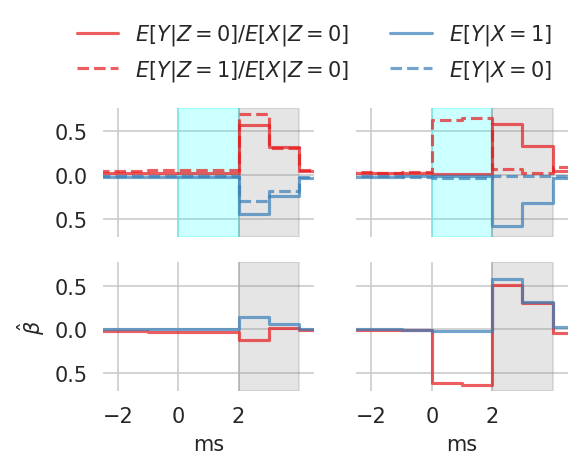

In [45]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, dpi=150, figsize=(4,2.5))
axs = axs.ravel()

A, B, C = trials[0], trials[1], trials[2]

AC = Connectivity(A, C, rparams)

BC = Connectivity(B, C, rparams)


times = np.arange(-10, 10)
kwarg = {
    'alpha': 0.7,
    'where': 'post',
#     'align': 'edge' # bar
        
}
axs[0].step(times, C[AC.z==0].mean(0) / AC.x[AC.z==0].mean(), color='#e41a1c', label='$E[Y|Z=0] / E[X|Z=0]$', **kwarg)
axs[0].step(times, C[AC.z==1].mean(0) / AC.x[AC.z==0].mean(), color='#e41a1c', label='$E[Y|Z=1] / E[X|Z=0]$', ls='--', **kwarg)

axs[0].step(times, -C[(AC.x==1)].mean(0), color='#377eb8', label='$E[Y|X=1]$', **kwarg)
axs[0].step(times, -C[(AC.x==0)].mean(0), color='#377eb8', label='$E[Y|X=0]$', ls='--', **kwarg)


axs[1].step(times, C[(BC.z==0)].mean(0) / BC.x[BC.z==0].mean(), color='#e41a1c', label='$P(Y|Z=0)$', **kwarg)
axs[1].step(times, C[(BC.z==1)].mean(0) / BC.x[BC.z==0].mean(), color='#e41a1c', label='$P(Y|Z=1)$', ls='--', **kwarg)

axs[1].step(times, -C[(BC.x==1)].mean(0), color='#377eb8', label='$P(Y|X=1)$', **kwarg)
axs[1].step(times, -C[(BC.x==0)].mean(0), color='#377eb8', label='$P(Y|X=0)$', ls='--', **kwarg)

axs[0].set_xlim(-2.5,4.5)
axs[0].set_yticklabels(np.abs(axs[0].get_yticks()).round(2))
sns.despine(left=True, bottom=True)
# axs[0].set_title('AC')
# axs[1].set_title('BC')
axs[0].axvspan(0, 2, color='cyan', alpha=.2)#, label='Stimuli')
axs[1].axvspan(0, 2, color='cyan', alpha=.2)
axs[0].axvspan(2, 4, color='gray', alpha=.2)#, label='Estimate')
axs[1].axvspan(2, 4, color='gray', alpha=.2)
# axs[0].legend(frameon=False)
# axs[1].legend(frameon=False)
# axs[0].legend(loc='upper left', bbox_to_anchor=(2.3, 1.15), frameon=False)
axs[0].legend(loc='lower center', bbox_to_anchor=(1, 1.05),frameon=False, ncol=2)


axs[2].step(
    times, 
    C[AC.z==0].mean(0) / AC.x[AC.z==0].mean()-C[AC.z==1].mean(0) / AC.x[AC.z==0].mean(), 
    color='#e41a1c', **kwarg)

axs[2].step(times, C[(AC.x==1)].mean(0) - C[(AC.x==0)].mean(0), color='#377eb8', **kwarg)


axs[3].step(
    times, 
    C[(BC.z==0)].mean(0) / BC.x[BC.z==0].mean() - C[(BC.z==1)].mean(0) / BC.x[BC.z==0].mean(), 
    color='#e41a1c', **kwarg)

axs[3].step(times, C[(BC.x==1)].mean(0) -C[(BC.x==0)].mean(0), color='#377eb8', **kwarg)

axs[2].axvspan(2, 4, color='gray', alpha=.2)
axs[3].axvspan(2, 4, color='gray', alpha=.2)
axs[2].set_xticks([-2,0,2])
axs[2].set_ylabel(r'$\hat{\beta}$')
axs[2].set_xlabel('ms')
axs[3].set_xlabel('ms')
savefig('sweep_0_three_neurons_expectancies')

In [16]:
from causal_optoconnectics.tools import roll_pad

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


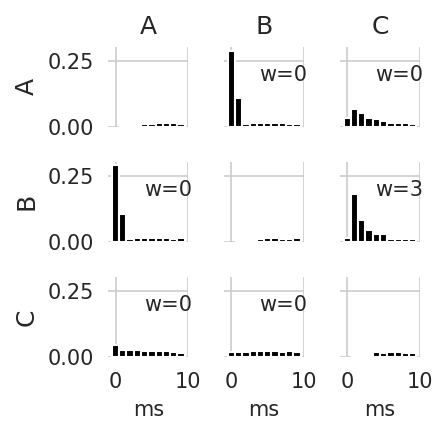

In [44]:
data = np.load(data_df.query('weight==3').iloc[0].path, allow_pickle=True)
x = decompress_events(data['data'][0], len(W), params['n_time_step'])
W_0 = data['W_0']

fig, axs = plt.subplots(len(W_0), len(W_0), figsize=(3,3), dpi=150, sharex=True, sharey=True)
n_step = 10
neuron_idx = [0, 1, 2]
for i, axr in enumerate(axs):
    for j, ax in enumerate(axr):
        neuron_i = x[neuron_idx[i]]
        neuron_j = x[neuron_idx[j]]
        skip = 1 if i==j else 0 # remove zero lag in neuron autocorrelation
        lags = np.arange(skip, n_step)
        shift = [(neuron_j * roll_pad(neuron_i, jj)).sum() / roll_pad(neuron_i, jj).sum() for jj in lags]
        ax.bar(
            lags, shift, width=1, 
            label=f'w={W_0[neuron_idx[i],neuron_idx[j]]:.0f}' if i!=j else '', 
            color='k')
    
        ax.legend(frameon=False, handlelength=0, loc='upper left')
        sns.despine(left=True, bottom=True)
        
for ax in axs[-1]:
    ax.set_xlabel('ms')
    
labels = {0:'A', 1:'B', 2:'C'}
    
for i, ax in enumerate(axs.T[0]):
    ax.set_ylabel(labels[i], fontsize=plt.rcParams['axes.titlesize'])
    
for i, ax in enumerate(axs[0]):
    ax.set_title(labels[i])
    
plt.tight_layout()
savefig('sweep_0_three_xcorr')